# Boiling Point of Compounds
Based on:
 1. S.-Y. Kim, I. Jeon and S.-J. Kang, "Integrating Data Science and Machine Learning to Chemistry Education: Predicting Classification and Boiling Point of Compounds", J. Chem. Educ., 101, 1771–1776 (2024). [doi:10.1021/acs.jchemed.3c01040](doi.org/10.1021/acs.jchemed.3c01040)


In [1]:
from pylab import *
import pandas as pd
import sklearn

## Functions

In [2]:
def plot_fun(bps, bp_predictions, t=None):
    plot(bps, bp_predictions,'o')
    plot(bps,bps)
    axis('square')
    xlabel('Boiling Point')
    ylabel('Predicted Boiling Point')
    title(t)
    show()

## Import data

In [3]:
data_url = 'https://raw.githubusercontent.com/woldr001/AIChE_Workshop_MSU/refs/heads/main/boiling_point_data.csv'
compounds = pd.read_csv(data_url)
compounds.head()

,cmpdname,BoilingPoint,mw,mf,polararea,heavycnt,hbondacc,isosmiles,C number,N number,O number,Side chain number,Double bond number,Triple bond number,Classify1
0,Ethylene Glycol,470.65,62.070,C2H6O2,40.5,4,2,C(CO)O,2,0,2,1,0,0,Alcohol
1,"2,3-Butanediol",455.15,90.120,C4H10O2,40.5,6,2,CC(C(C)O)O,4,0,2,2,0,0,Alcohol
2,1-Butanol,390.75,74.120,C4H10O,20.2,5,1,CCCCO,4,0,1,0,0,0,Alcohol
3,Methane,111.65,16.043,CH4,0.0,1,0,C,1,0,0,0,0,0,Hydrocarbon
4,Octane,398.77,114.230,C8H18,0.0,8,0,CCCCCCCC,8,0,0,0,0,0,Hydrocarbon


## Training Set and Test Set

In [4]:
def split_data_with_id_hash(data, test_ratio, id_column):

    from zlib import crc32

    def is_id_in_test_set(identifier, test_ratio):
      return crc32(np.int64(identifier)) < test_ratio * 2**32

    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [5]:
compounds = compounds.reset_index()
train_set, test_set = split_data_with_id_hash(compounds, 0.2, "index")

In [6]:
len(train_set), len(test_set)

(1398, 350)

## Data Exploration

### Histograms

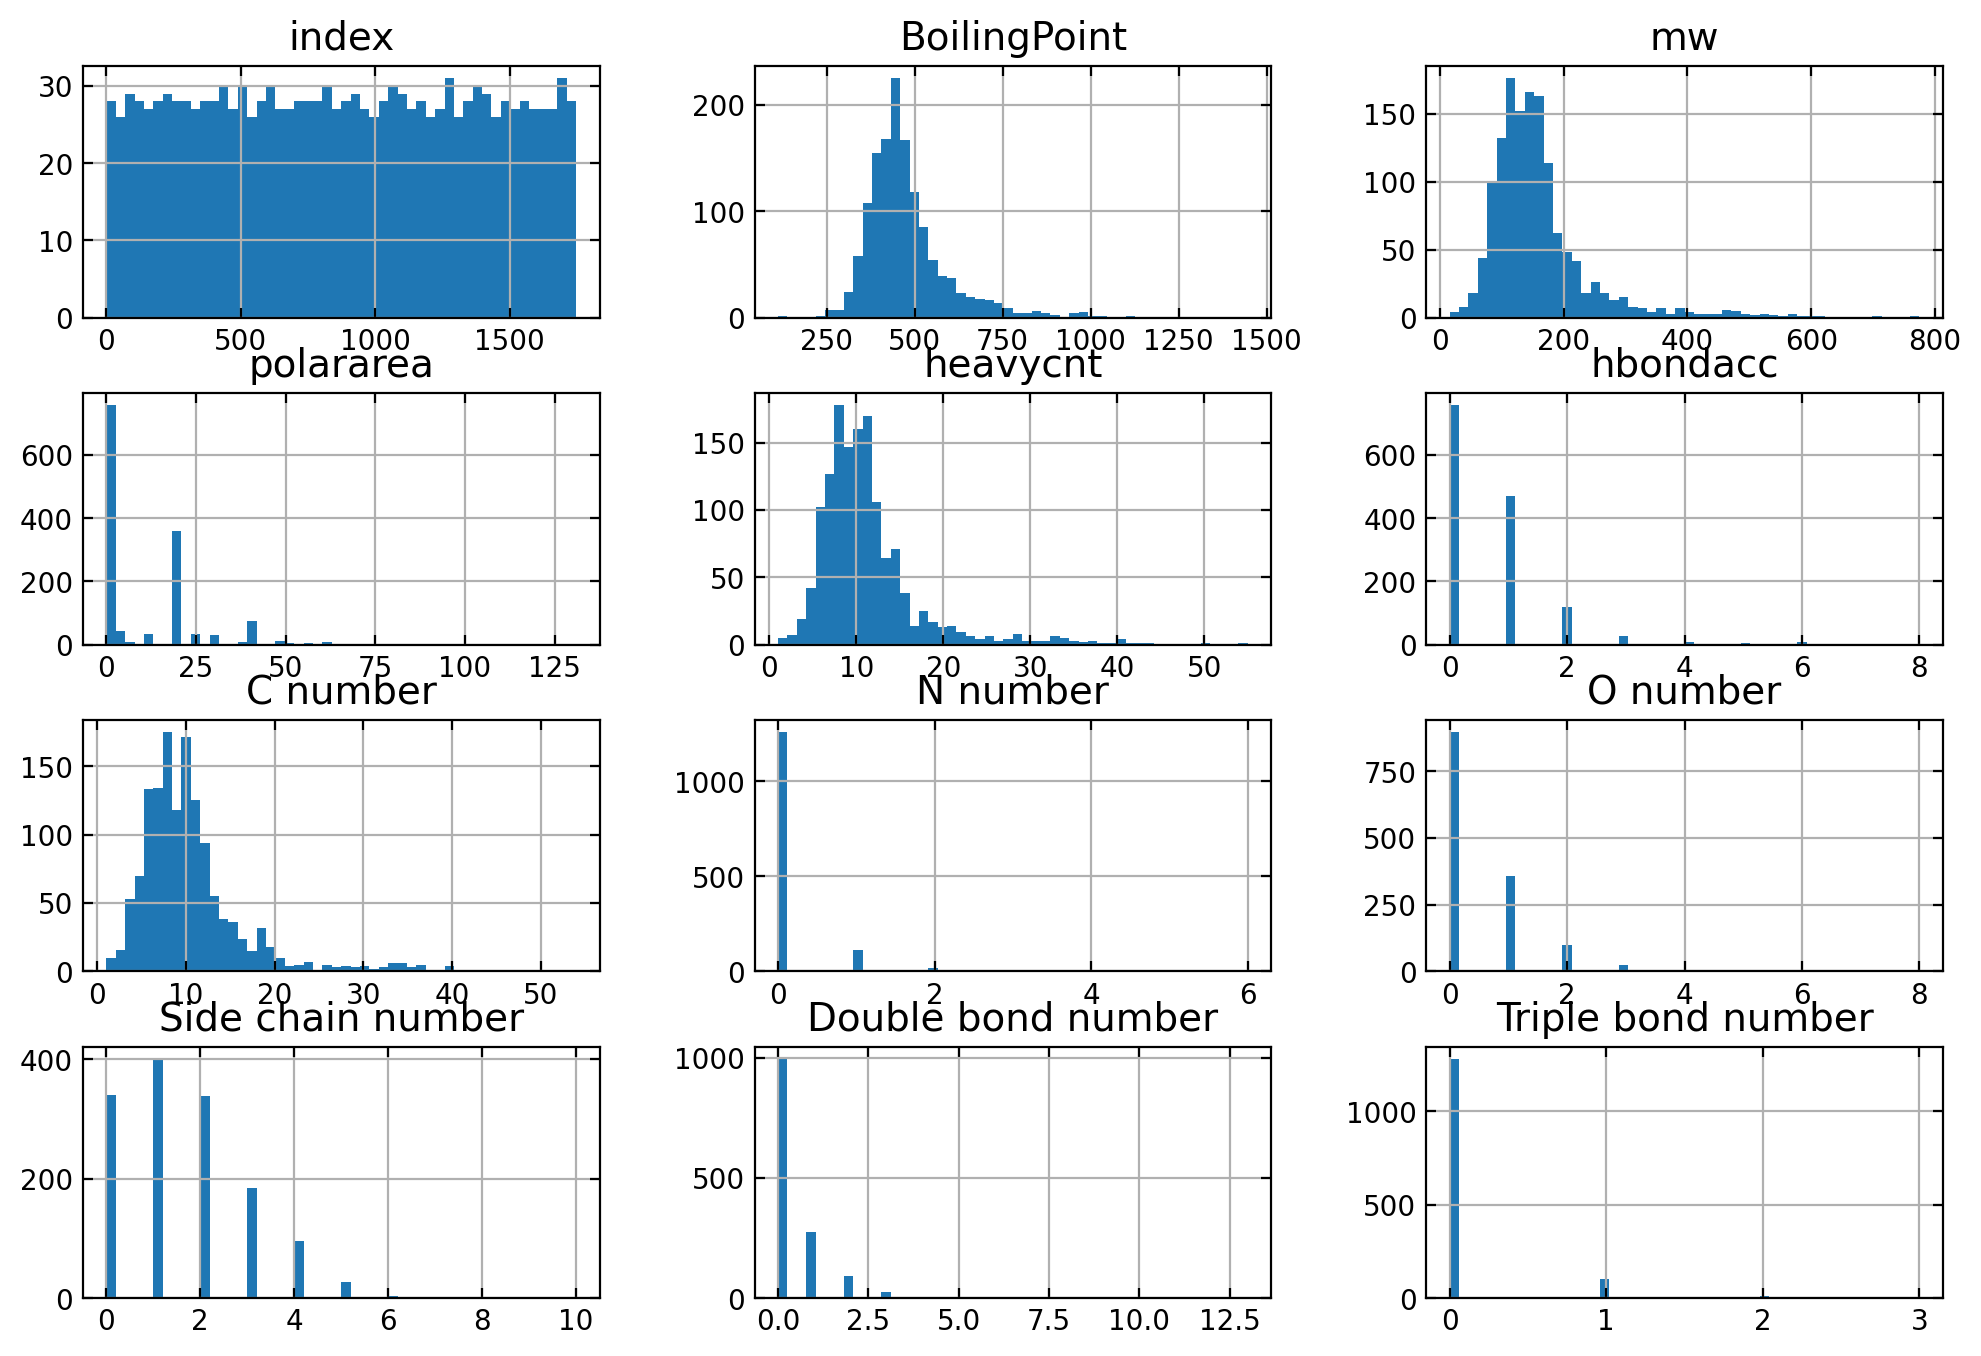

In [7]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

train_set.hist(bins=50, figsize=(12, 8))
plt.show()

### Correlations

In [8]:
cols = ['BoilingPoint', 'mw', 'polararea', 'heavycnt',
       'hbondacc', 'C number', 'N number', 'O number',
       'Side chain number', 'Double bond number', 'Triple bond number']
corr_matrix = train_set[cols].corr()
corr_matrix

,BoilingPoint,mw,polararea,heavycnt,hbondacc,C number,N number,O number,Side chain number,Double bond number,Triple bond number
BoilingPoint,1.000000,0.901435,0.206036,0.895885,0.210724,0.848148,-0.011990,0.226321,0.042129,-0.112495,-0.087090
mw,0.901435,1.000000,-0.057415,0.999418,-0.008058,0.983575,0.002456,-0.009668,0.012054,-0.102778,-0.107748
polararea,0.206036,-0.057415,1.000000,-0.081679,0.944392,-0.225851,0.250145,0.860231,0.011919,-0.177504,-0.072848
heavycnt,0.895885,0.999418,-0.081679,1.000000,-0.033386,0.988051,-0.003116,-0.033314,0.007581,-0.082140,-0.092972
hbondacc,0.210724,-0.008058,0.944392,-0.033386,1.000000,-0.186968,0.329698,0.878020,-0.019256,-0.189898,-0.083640
C number,0.848148,0.983575,-0.225851,0.988051,-0.186968,1.000000,-0.053881,-0.168097,0.010386,-0.051375,-0.078436
N number,-0.011990,0.002456,0.250145,-0.003116,0.329698,-0.053881,1.000000,-0.162380,-0.084467,-0.131163,-0.070732
O number,0.226321,-0.009668,0.860231,-0.033314,0.878020,-0.168097,-0.162380,1.000000,0.022696,-0.131979,-0.051559
Side chain number,0.042129,0.012054,0.011919,0.007581,-0.019256,0.010386,-0.084467,0.022696,1.000000,-0.092460,-0.171591
Double bond number,-0.112495,-0.102778,-0.177504,-0.082140,-0.189898,-0.051375,-0.131163,-0.131979,-0.092460,1.000000,-0.115708


### Scatter Plot

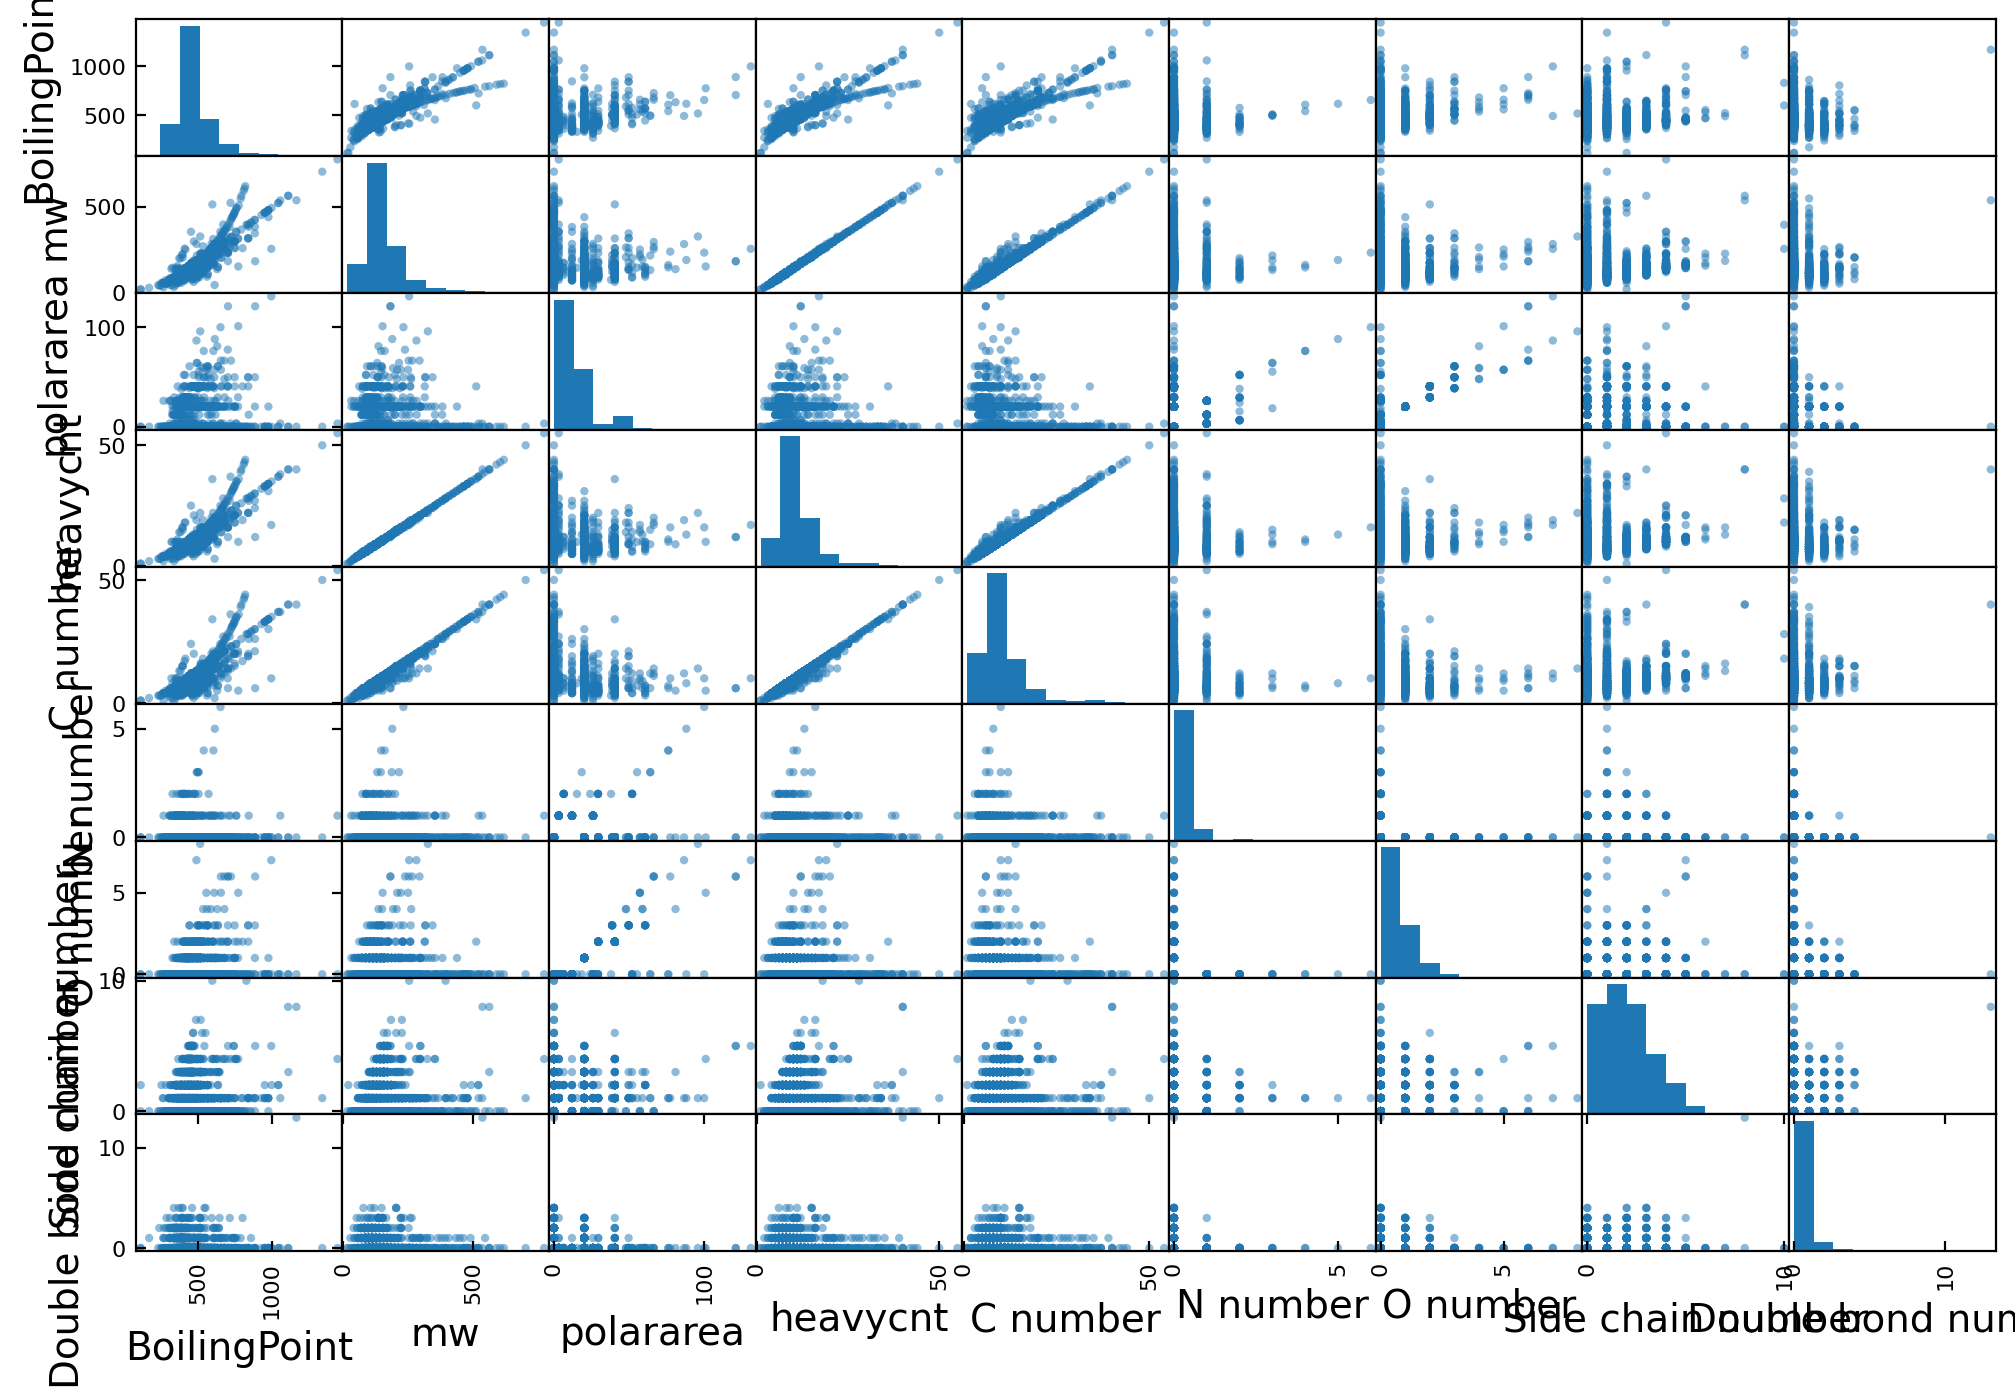

In [9]:
from pandas.plotting import scatter_matrix
cols = ['BoilingPoint', 'mw', 'polararea', 'heavycnt',
        'C number', 'N number', 'O number',
       'Side chain number', 'Double bond number',]
scatter_matrix(train_set[cols], figsize=(12, 8))
show()

## Prepare for ML

### define labels

In [10]:
compounds=train_set.drop('BoilingPoint', axis=1)
bps = train_set['BoilingPoint'].copy()

### Encode category

In [11]:
compounds_category = compounds[["Classify1"]]
compounds_category.head()

,Classify1
0,Alcohol
1,Alcohol
3,Hydrocarbon
4,Hydrocarbon
6,Alcohol


In [12]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
compounds_cat_1hot = cat_encoder.fit_transform(compounds_category)
compounds_cat_1hot[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [13]:
cat_encoder.categories_

[array(['Alcohol', 'Amine', 'Hydrocarbon'], dtype=object)]

### Feature Scaling

We'll skip this for now...

In [14]:
sklearn.set_config(display='diagram')

### Create Pipeline

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [16]:
from sklearn.compose import ColumnTransformer

num_attribs = ['mw', 'polararea', 'heavycnt',
       'hbondacc', 'C number', 'N number', 'O number',
       'Side chain number', 'Double bond number', 'Triple bond number']
cat_attribs = ["Classify1"]

cat_pipeline = make_pipeline(
  SimpleImputer(strategy="most_frequent"),
  OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
  ("num", num_pipeline, num_attribs),
  ("cat", cat_pipeline, cat_attribs),
])

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['mw', 'polararea', 'heavycnt', 'hbondacc',
                                  'C number', 'N number', 'O number',
                                  'Side chain number', 'Double bond number',
                                  'Triple bond number']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Classify1'])])

In [17]:
compounds_prepared = preprocessing.fit_transform(compounds)
compounds_prepared

array([[-1.14968525,  1.76371677, -1.20031809, ...,  1.        ,
         0.        ,  0.        ],
       [-0.81998664,  1.76371677, -0.86960373, ...,  1.        ,
         0.        ,  0.        ],
       [-1.69068482, -0.70268994, -1.69638964, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.34854702,  0.52746847, -0.37353218, ...,  1.        ,
         0.        ,  0.        ],
       [-0.34854702,  0.52746847, -0.37353218, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.97037671,  0.52746847,  0.94932529, ...,  1.        ,
         0.        ,  0.        ]], shape=(1398, 13))

In [18]:
preprocessing.get_feature_names_out()

array(['num__mw', 'num__polararea', 'num__heavycnt', 'num__hbondacc',
       'num__C number', 'num__N number', 'num__O number',
       'num__Side chain number', 'num__Double bond number',
       'num__Triple bond number', 'cat__Classify1_Alcohol',
       'cat__Classify1_Amine', 'cat__Classify1_Hydrocarbon'], dtype=object)

## Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(compounds, bps)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['mw', 'polararea',
                                                   'heavycnt', 'hbondacc',
                                                   'C number', 'N number',
                                                   'O number',
                                                   'Side chain number',
                                                   'Double bond number',
                                                   'Triple bond number']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Classify1'])])),
                ('linearregression', LinearRegression())])

In [20]:
bp_predictions = lin_reg.predict(compounds)
bp_predictions[:5]

array([406.85662925, 447.82811348, 249.94502017, 385.07202515,
       339.19677756])

In [21]:
bps.iloc[:5]

0    470.65
1    455.15
3    111.65
4    398.77
6    351.39
Name: BoilingPoint, dtype: float64

In [22]:
from sklearn.metrics import root_mean_squared_error
lin_rmse = root_mean_squared_error(bps, bp_predictions)
lin_rmse

40.670739579223216

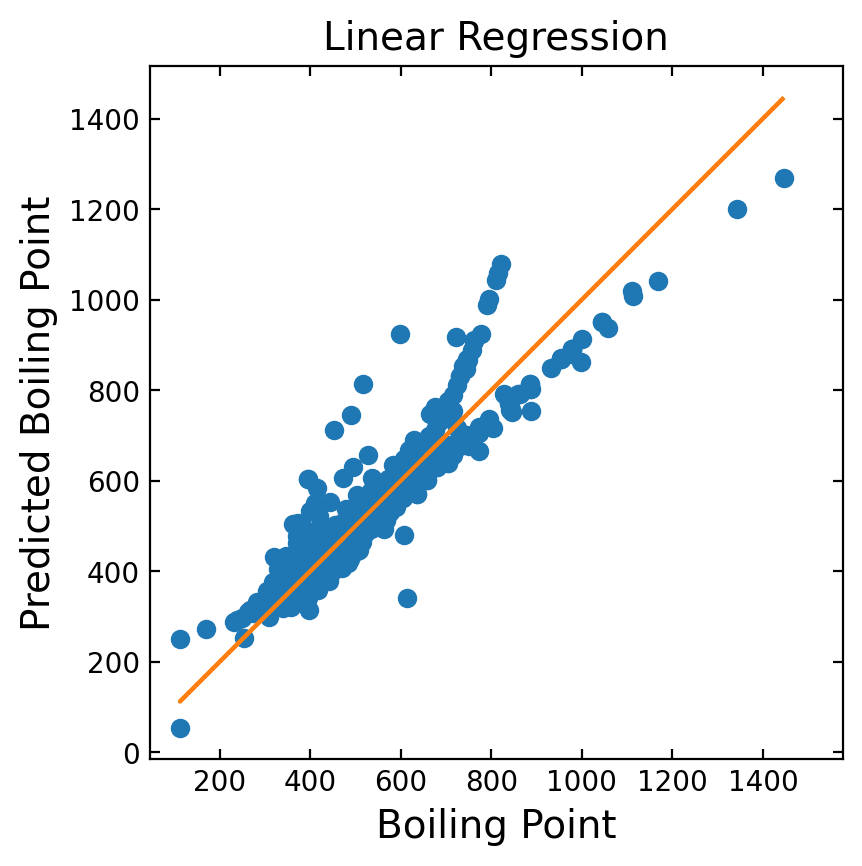

In [23]:
plot_fun(bps, bp_predictions, 'Linear Regression')

### Cross-Validation

In [24]:
from sklearn.model_selection import cross_val_score

lin_rmses = -cross_val_score(lin_reg, compounds, bps,
                            scoring="neg_root_mean_squared_error", cv=10)

In [25]:
lin_rmses

array([43.23322527, 44.89221186, 50.40467533, 48.12250553, 51.49315954,
       34.72795025, 40.99399251, 39.75964597, 38.92345864, 30.76232771])

In [26]:
pd.Series(lin_rmses).describe()

count    10.000000
mean     42.331315
std       6.680786
min      30.762328
25%      39.132505
50%      42.113609
75%      47.314932
max      51.493160
dtype: float64

## Decision Tree

In [27]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(compounds, bps)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['mw', 'polararea',
                                                   'heavycnt', 'hbondacc',
                                                   'C number', 'N number',
                                                   'O number',
                                                   'Side chain number',
                                                   'Double bond number',
                                                   'Triple bond number']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Classify1'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [28]:
bp_predictions = tree_reg.predict(compounds)
tree_rmse = root_mean_squared_error(bps, bp_predictions)
tree_rmse

13.308395769256949

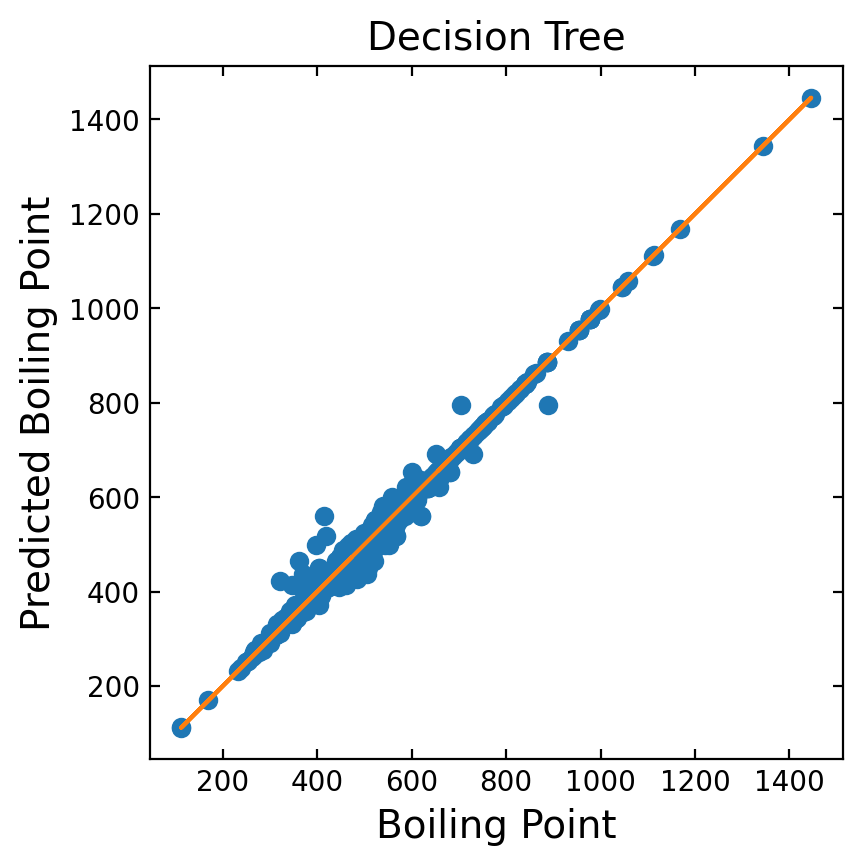

In [29]:
plot_fun(bps, bp_predictions, 'Decision Tree')

### Cross-Validation

In [30]:
tree_rmses = -cross_val_score(tree_reg, compounds, bps,
                            scoring="neg_root_mean_squared_error", cv=10)

In [31]:
tree_rmses

array([50.56784074, 38.4131516 , 38.71549986, 60.28218801, 54.75053587,
       23.85434464, 37.75352742, 30.16157117, 39.43131283, 18.54857893])

In [32]:
pd.Series(tree_rmses).describe()

count    10.000000
mean     39.247855
std      13.174664
min      18.548579
25%      32.059560
50%      38.564326
75%      47.783709
max      60.282188
dtype: float64

## Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                       RandomForestRegressor(random_state=42))
forest_reg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['mw', 'polararea',
                                                   'heavycnt', 'hbondacc',
                                                   'C number', 'N number',
                                                   'O number',
                                                   'Side chain number',
                                                   'Double bond number',
                                                   'Triple bond number']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Classify1'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [34]:
forest_reg.fit(compounds, bps)

bp_predictions = forest_reg.predict(compounds)

forest_rmses = -cross_val_score(forest_reg, compounds, bps,
                            scoring="neg_root_mean_squared_error", cv=10)

In [35]:
pd.Series(forest_rmses).describe()

count    10.000000
mean     37.390879
std       9.648951
min      24.965670
25%      28.644515
50%      37.363675
75%      43.770405
max      51.744125
dtype: float64

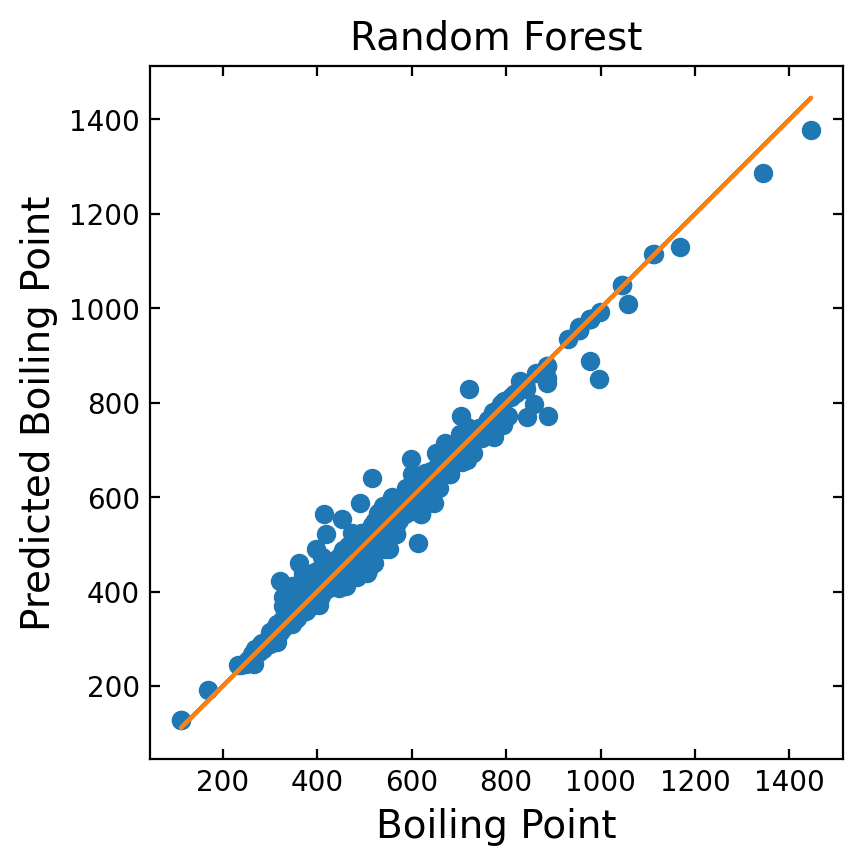

In [36]:
plot_fun(bps, bp_predictions, 'Random Forest')

### Feature Importance

In [37]:
feature_importances = forest_reg['randomforestregressor'].feature_importances_
feature_names = preprocessing.get_feature_names_out()

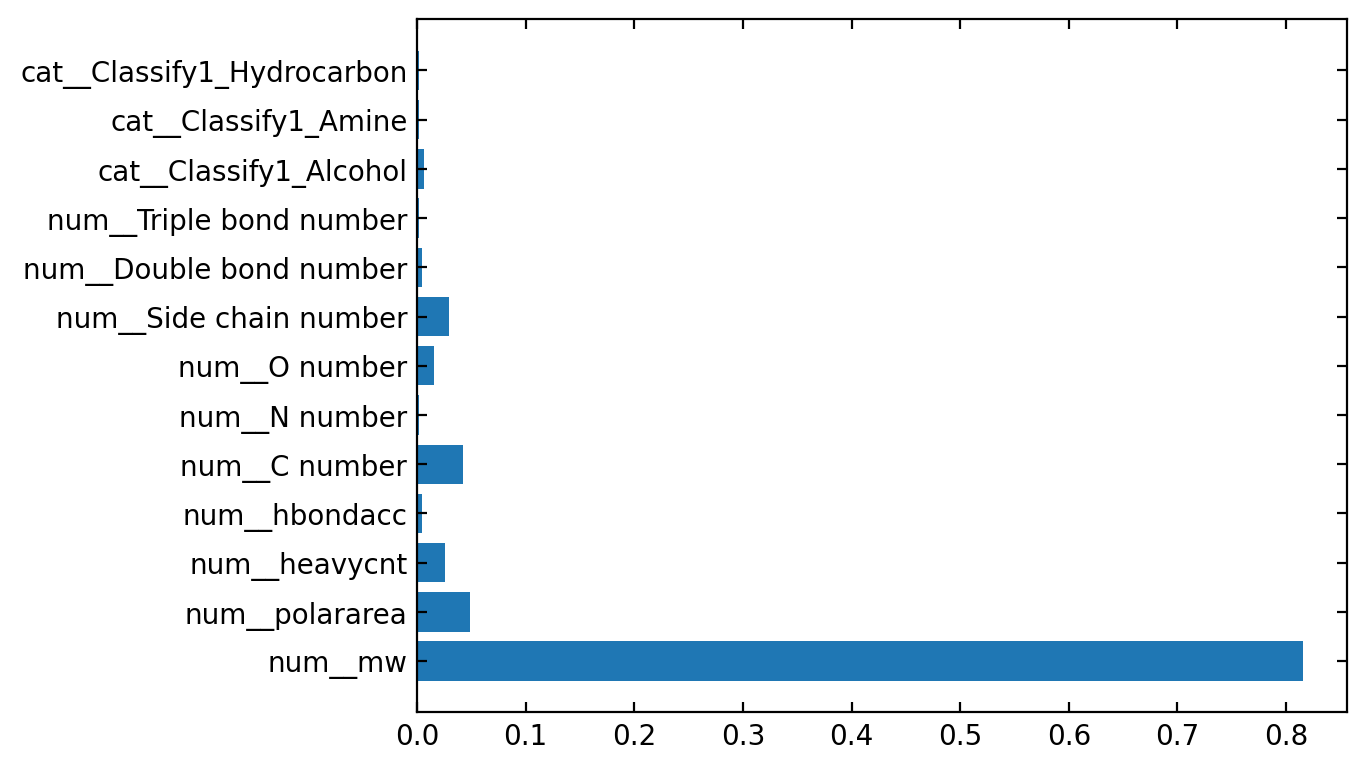

In [38]:
barh(feature_names, feature_importances)
show()

## Compare to Test Data

In [39]:
test_bps = test_set['BoilingPoint'].copy()
test_predictions = forest_reg.predict(test_set)

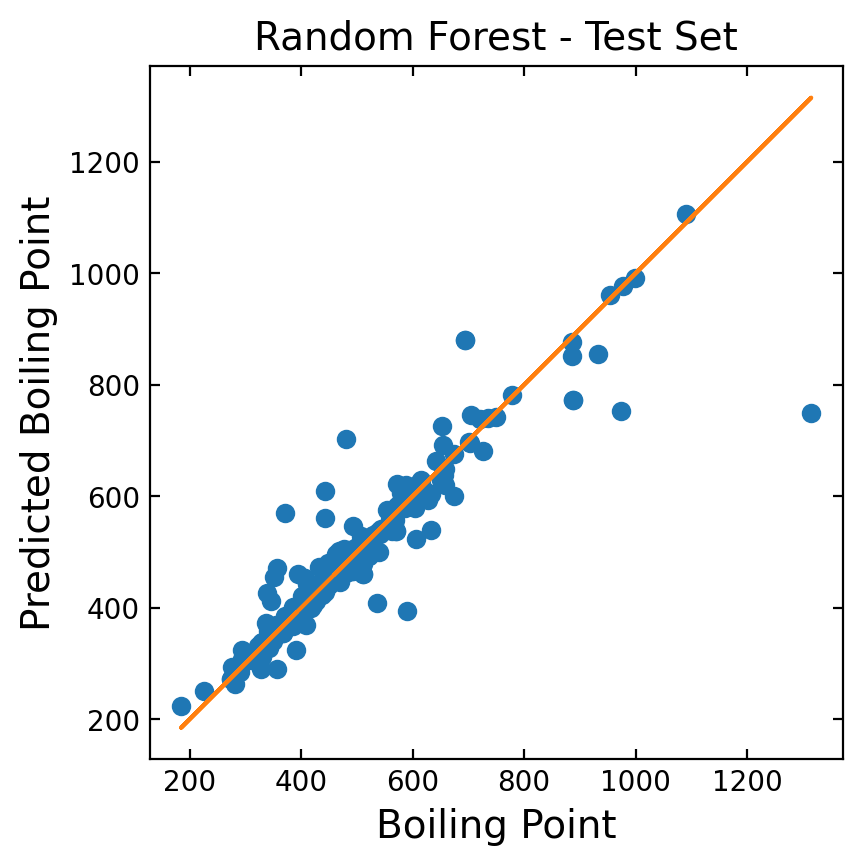

In [40]:
plot_fun(test_bps, test_predictions, 'Random Forest - Test Set')

In [41]:
final_rmse = root_mean_squared_error(test_bps, test_predictions)
print(final_rmse)

48.056840470056514


In [42]:
from sklearn.neural_network import MLPRegressor

In [43]:
mlp_regressor = MLPRegressor(solver='lbfgs', max_iter=1000)

MLP_reg = make_pipeline(preprocessing, mlp_regressor )
MLP_reg.fit(compounds, bps)

bp_predictions = MLP_reg.predict(compounds)

MLP_rmses = -cross_val_score(MLP_reg, compounds, bps,
                            scoring="neg_root_mean_squared_error", cv=10)

/Users/scott/opt/venv/jupyterlab/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/scott/opt/venv/jupyterlab/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/scott/opt/venv/jupyterlab/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lb

In [44]:
pd.Series(MLP_rmses).describe()

count    10.000000
mean     46.008433
std      13.271660
min      29.096283
25%      38.705709
50%      42.125277
75%      50.989006
max      70.074729
dtype: float64

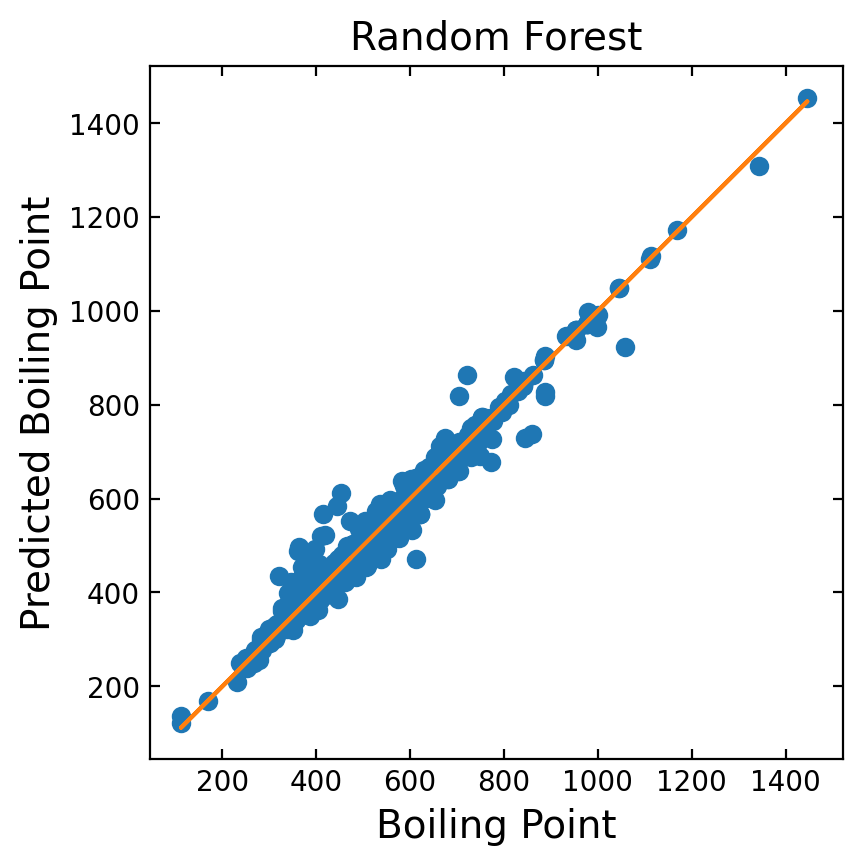

In [45]:
plot(bps, bp_predictions,'o')
plot(bps,bps)
axis('square')
xlabel('Boiling Point')
ylabel('Predicted Boiling Point')
title('Random Forest')
show()